In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Prediction de la consommation d'énergie**

In [2]:
# import des principales bibliothèques 
from matplotlib import pyplot as plt
import seaborn as sns
import time 
from datetime import datetime
import pandas as pd
import os
sns.set()
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from matplotlib.patches import FancyArrowPatch
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot, prediction_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import svm
import folium
import time
from datetime import datetime
from geopy.distance import geodesic
from pandas.core.groupby.generic import DataFrameGroupBy

In [3]:
# Fonction permettant de calculer le RMSPE
# source : https://stackoverflow.com/questions/53165807/how-to-calculate-rmspe-in-python-using-numpy
def rmpse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss

In [4]:
# Fonction d'évaluation des modèles de régression
def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmpse_cal = rmpse(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("RMPSE: ", rmpse_cal.round(3))
    print("MAPE: ", mape.round(5))
    print("R²: ", r_score.round(5))

## I-Chargement des données


In [5]:
# chargement des données
path = "/content/gdrive/My Drive/P3/2016-building-energy-benchmarking.csv"
data_build = pd.read_csv(path)

In [6]:
data_build.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [7]:
# selection de certaines variables
data=data_build.copy()
data=data[['BuildingType', 'YearBuilt','LargestPropertyUseType','DataYear','PrimaryPropertyType','Neighborhood',
           'NumberofFloors','NumberofBuildings','LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
           'PropertyGFATotal','Latitude','Longitude','ENERGYSTARScore','SiteEnergyUseWN(kBtu)','TotalGHGEmissions']]
data=pd.concat([data.select_dtypes('object'),data.select_dtypes('int64'),data.select_dtypes('float')],axis=1)



In [8]:
data['Age']=data['DataYear']-data['YearBuilt']

In [9]:
data.select_dtypes('float').corr()

,NumberofBuildings,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,Latitude,Longitude,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions
NumberofBuildings,1.000000,0.758749,0.112821,0.000981,0.020646,0.017858,-0.004900,0.090486,0.405261
LargestPropertyUseTypeGFA,0.758749,1.000000,0.769156,0.455648,-0.015277,0.029323,0.058088,0.393574,0.578487
SecondLargestPropertyUseTypeGFA,0.112821,0.769156,1.000000,0.662280,-0.052773,0.018545,0.082980,0.626631,0.506537
ThirdLargestPropertyUseTypeGFA,0.000981,0.455648,0.662280,1.000000,-0.107349,0.027265,-0.010977,0.753857,0.677722
Latitude,0.020646,-0.015277,-0.052773,-0.107349,1.000000,0.005250,0.079948,-0.041985,-0.026089
Longitude,0.017858,0.029323,0.018545,0.027265,0.005250,1.000000,-0.026404,0.032156,0.037411
ENERGYSTARScore,-0.004900,0.058088,0.082980,-0.010977,0.079948,-0.026404,1.000000,-0.090163,-0.101633
SiteEnergyUseWN(kBtu),0.090486,0.393574,0.626631,0.753857,-0.041985,0.032156,-0.090163,1.000000,0.859042
TotalGHGEmissions,0.405261,0.578487,0.506537,0.677722,-0.026089,0.037411,-0.101633,0.859042,1.000000


On s'interesse uniquement aux batiments non residentiels sur le type de construction.

In [10]:
# Transformation logarithmique des variables cibles
# L'analyse exploratoire a montré qu'elles ne suivaient pas une loi normale
data=data.loc[data['BuildingType'].isin(['NonResidential','Nonresidential COS','Nonresidential WA']),:]
data=data.loc[data['SiteEnergyUseWN(kBtu)']>0]
dat=data[['SiteEnergyUseWN(kBtu)','TotalGHGEmissions']]
data['SiteEnergyUseWN(kBtu)'+"_"+"log"]=np.log(data['SiteEnergyUseWN(kBtu)'])



OneHotEncoding

Une fois que l'on a chargé les données, on va pouvoir séparer notre jeu de données en deux parties : un train set et un test set. On ne va pas toucher aux données du test set car il nous servia pour la validation de notre modèle. C'est grâce à ce jeu de données que l'on pourra sortir les metrics nécessaires. Dans chaque jeu (entraînement et test), on supprime les variables qui ne seront pas utiles dans notre modélisation. 

Tout d'abord, on supprime les variables que l'on cherche à prédire. "SiteEnergyUseWN(kBtu)" et "TotalGHGEmissions" sont les deux cibles que l'on cherche à prédire, on les mettra donc dans une variable y. Ensuite, notre jeu de données comporte de nombreuses valeurs : certaines sont d'origine et d'autres proviennent d'une opération de feature engineering. On va donc supprimer les doublons pour éviter la fuite de donneés. 
- Le score ENERGYSTAR est enlevé car on ne va pas s'en servir pour prédire la consommation d'énergie. On regardera son impact dans la prédiction des effets de gaz à effets de serre dans un second temps. 


In [11]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété"
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)


In [12]:
y_train = train_set[["SiteEnergyUseWN(kBtu)_log"]]
y_test = test_set[["SiteEnergyUseWN(kBtu)_log"]]
X_train = train_set.drop([ "SiteEnergyUseWN(kBtu)_log",'SiteEnergyUseWN(kBtu)', "TotalGHGEmissions", 'ENERGYSTARScore','YearBuilt','DataYear','Latitude','Longitude'], axis=1)
X_test = test_set.drop([ "SiteEnergyUseWN(kBtu)_log", 'SiteEnergyUseWN(kBtu)',"TotalGHGEmissions",'ENERGYSTARScore','YearBuilt','DataYear','Latitude','Longitude'], axis=1)


In [13]:
# Séparation des variables catégorielles et numériques
cat_var = ['BuildingType', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
num_var = ['NumberofFloors', 'PropertyGFATotal', 'NumberofBuildings', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA', 'Age']
colums=cat_var + num_var

In [14]:
# Création d'un pipeline de transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [15]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)
X_test= preprocessor.transform(X_test)

## **I-Prédiction de la consommation de l'énergie sans EnergyStar score**

### **1- Algorithmes de Machine Learning**

In [ ]:
results = pd.DataFrame({})

**1.1-Création du modèle de base**

Le modèle choisi pour obtenir une baseline est un modèle naïf. Ce type de modèle prédit la valeur médiane de la variable cible. Le but étant d'avoir une prédiction proche de ce que ferait un modèle basé sur le hasard. 

In [ ]:
from numpy.core.function_base import linspace
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor()
parameters={'strategy':['mean', 'median', 'quantile','constant'],
            'quantile': linspace(0.01, 1.0,5),
            'constant' : ['float','int']}
dummy_grid=GridSearchCV(dummy_reg,parameters,cv=5)  
training_start = time.perf_counter()
dummy_reg.fit(X_train, y_train)
training_end = time.perf_counter()   


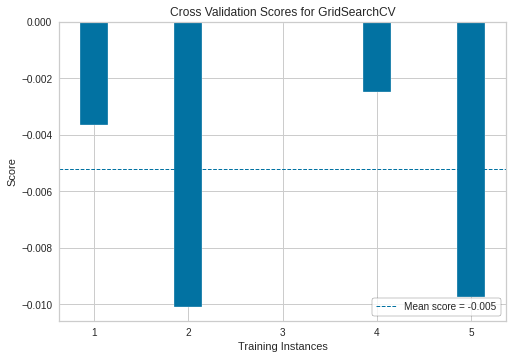

In [ ]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
#cv = KFold(n_splits=12, shuffle=True, random_state=42)

model = dummy_grid
visualizer1 = cv_scores(model, X_train, y_train, scoring='r2')

In [ ]:
visualizer1.cv_scores_mean_

-0.005197958114022017

In [ ]:
dummy_reg.score(X_train,y_train)

0.0

In [ ]:
dummy_reg_train_time = training_end-training_start
dummy_reg_train_time

0.0018278200004715472

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Dummyregressor'],
    'Train_Score' : [dummy_reg.score(X_train,y_train)],'cv_scores_mean_':[visualizer1.cv_scores_mean_],'Time_train':[dummy_reg_train_time]}),ignore_index=True)

**1.2-Linear Regression / Ridge Regression / Lasso / Elastic Net**

Le modèle Elastic Net comprend les modèles linéaires / ridge et lasso via les valeurs des coefficients dans le grid search CV

In [ ]:
from sklearn.linear_model import ElasticNet
#rappel de la fonction de coût du elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge

elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,cv=5)
                      
training_start_elast = time.perf_counter()
elastic_grid.fit(X_train, y_train)
training_end_elast = time.perf_counter()   
               


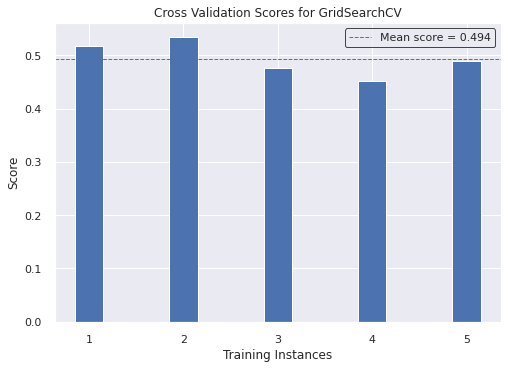

In [ ]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
#cv = KFold(n_splits=12, shuffle=True, random_state=42)

model = elastic_grid
visualizer2 = cv_scores(model, X_train, y_train, scoring='r2')

In [ ]:
visualizer2.cv_scores_mean_

0.49372908462294784

In [ ]:
elastic_grid.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=0.4, tol=0.001)

In [ ]:
elastic_grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.4, 'tol': 0.001}

In [ ]:
elastic_grid.score(X_train,y_train)

0.5868881144407052

In [ ]:
elastic_grid_train_time = training_end_elast-training_start_elast
elastic_grid_train_time

62.30057335700076

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['ElasticNet'],
    'Train_Score' : [elastic_grid.score(X_train,y_train)],'cv_scores_mean_':[visualizer2.cv_scores_mean_],'Time_train':[elastic_grid_train_time]}),ignore_index=True)

**1.3-SVR**

In [ ]:
from sklearn.svm import SVR

parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,cv=5)
training_start_svm = time.perf_counter()
svm.fit(X_train, y_train)
training_end_svm = time.perf_counter()   
               



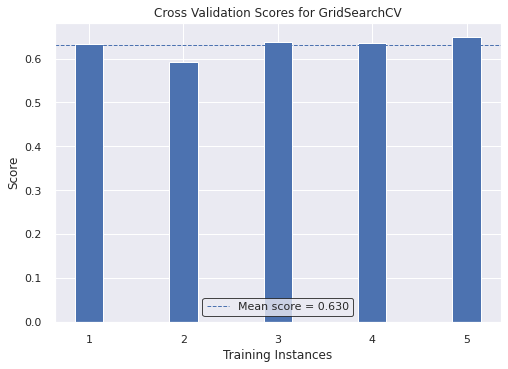

In [ ]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
#cv = KFold(n_splits=12, shuffle=True, random_state=42)

model = svm
visualizer3 = cv_scores(model, X_train, y_train, scoring='r2')

In [ ]:
visualizer3.cv_scores_mean_

0.6299858061670991

In [ ]:
svm.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 0.1}

In [ ]:
svm.best_estimator_

SVR(C=10, gamma=0.1)

In [ ]:
svm_train_time = training_end_svm-training_start_svm
svm_train_time

104.9705821209991

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['SVR'],
    'Train_Score' : [svm.score(X_train,y_train)],'cv_scores_mean_':[visualizer3.cv_scores_mean_],'Time_train':[svm_train_time]}),ignore_index=True)

**1.4- Random forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators' : [50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}    
        
rfr_search = GridSearchCV(RandomForestRegressor(),parameters, cv=5)
training_start_rfr = time.perf_counter()
rfr_search.fit(X_train, y_train)
training_end_rfr = time.perf_counter()   
               

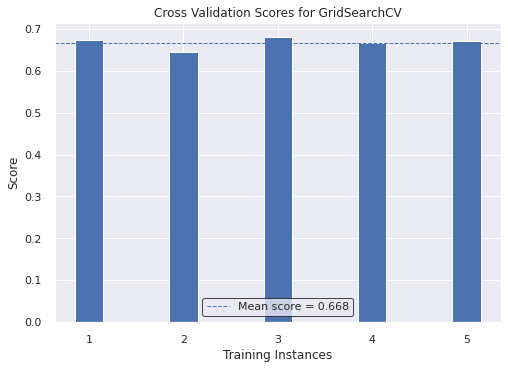

In [ ]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
#cv = KFold(n_splits=12, shuffle=True, random_state=42)

model = rfr_search
visualizer4= cv_scores(model, X_train, y_train, scoring='r2')

In [ ]:
visualizer4.cv_scores_mean_

0.6675819735384728

In [ ]:
rfr_search.score(X_train,y_train)

0.9559597674731776

In [ ]:
rfr_search.best_estimator_

RandomForestRegressor(max_features='sqrt', n_estimators=500)

In [ ]:
rfr_search_train_time = training_end_rfr - training_start_rfr
rfr_search_train_time

165.14132523700027

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Randomforest'],
    'Train_Score' : [rfr_search.score(X_train,y_train)],'cv_scores_mean_':[visualizer4.cv_scores_mean_],'Time_train':[rfr_search_train_time]}),ignore_index=True)

**1.5- XGBOOST**

In [16]:
from scipy.stats import randint
import xgboost as xgb
xgboost = xgb.XGBRegressor(n_jobs=-1)
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              "n_estimators" :[200,500,800,1000]}
xgb_search = GridSearchCV(xgboost,parameters,cv=5)
training_start_xgb = time.perf_counter()
xgb_search.fit(X_train, y_train)
training_end_xgb = time.perf_counter()   
               


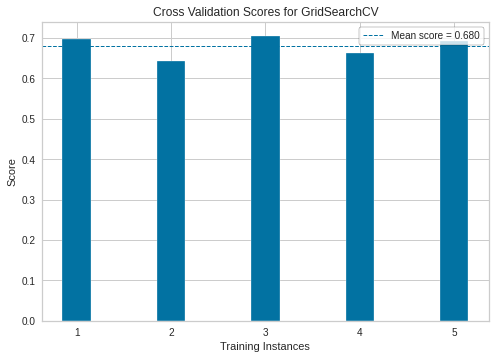

In [ ]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
#cv = KFold(n_splits=12, shuffle=True, random_state=42)

model = xgb_search
visualizer5 = cv_scores(model, X_train, y_train, scoring='r2')

In [ ]:
visualizer5.cv_scores_mean_

0.6797685131278124

In [ ]:
xgb_search.best_estimator_

XGBRegressor(n_estimators=200, n_jobs=-1, objective='reg:squarederror')

In [ ]:
xgb_search.score(X_train,y_train)

0.814295410086189

In [ ]:
xgb_train_time = training_end_xgb - training_start_xgb
xgb_train_time

56.14372606500001

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Xgboost'],
    'Train_Score' : [xgb_search.score(X_train,y_train)],'cv_scores_mean_':[visualizer5.cv_scores_mean_],'Time_train':[xgb_train_time]}),ignore_index=True)

##**2- Comparaison des modèles**

In [ ]:
results

,Modèle,Train_Score,cv_scores_mean_,Time_train
0,Dummyregressor,0.000000,-0.005198,0.001828
1,ElasticNet,0.586888,0.493729,62.300573
2,SVR,0.823467,0.629986,104.970582
3,Randomforest,0.955960,0.667582,165.141325
4,Xgboost,0.814295,0.679769,61.886445


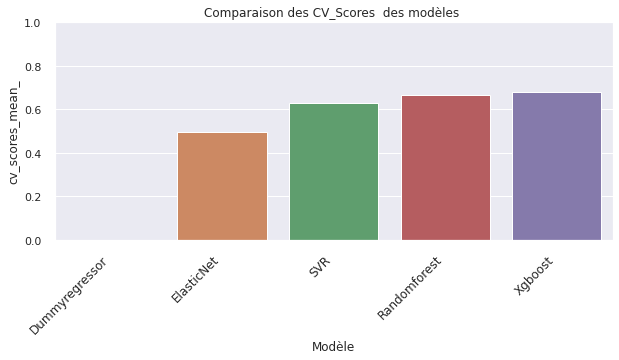

In [ ]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des CV_Scores  des modèles ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,2])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0,1])
plt.show()

* **XGBOOST** et **Randomforest** ont les meilleurs score de crosse avlidation par rapport aux autres modèles.

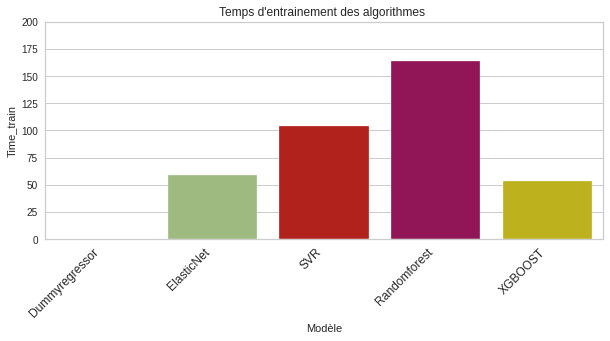

In [ ]:

plt.figure(figsize=(10,4))
plt.title('Temps d\'entrainement des algorithmes ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,3])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 200])
plt.show()

Le temps d'exécution de XGBoost est plus faible que celui de random forest, ce pourrait être un critère pour choisir éventuellement le **XGBoost** plutôt que le Random Forest Regressor.

##**3- Analyse des erreurs du meilleur modèle**

In [17]:
final_model_energy = xgb_search.best_estimator_
final_predictions_energy = final_model_energy.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.45762
MSE:  0.37722
RMSE:  0.6141827260317937
RMPSE:  0.117
MAPE:  0.03177
R²:  0.7715


L'évaluation finale de notre modèle montre des scores plutôt bons. Notre modèle estime la consommation d'énergie avec une erreur de plus ou moins 0.12%. Il a un coefficient de détermination de 77%, c'est-à-dire qu'il permet d'expliquer 77% de la variance observée dans nos variables cibles. De plus, l'erreur moyenne est de 0.03% (MAPE).

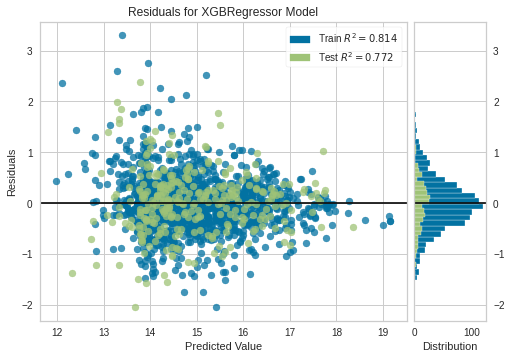

In [ ]:
visualizer = ResidualsPlot(final_model_energy)
visualizer.fit(np.array(X_train), np.array(y_train).reshape( 1226,))
visualizer.score(np.array(X_test), np.array(y_test).reshape(307  ,))
visualizer.show();

Les distributions des résidus du jeu d'entraînement et du jeu de test semblent suivre une loi normale. La distribution des résidus du jeu de test est plus aplatie. Cela peut s'expliquer par le nombre de données moins importants (seulement 20% de l'échantillon). 

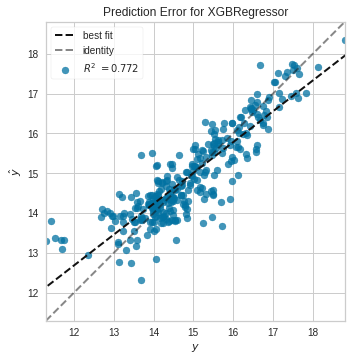

In [ ]:
visualizer = prediction_error(final_model_energy, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));

L'analyse des erreurs de prédiction ne montre pas d'anomalie particulière dans notre modèle. On peut donc l'enregistrer dans un pipeline pour pouvoir le déployer le moment venu.

##**4- Bilan du modèle**
   **4.1- Feature importances**

In [35]:
feature_importance = xgb_search.best_estimator_.feature_importances_
cat_encoder = preprocessor.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder[1].categories_)
cat_one = list(cat_one_hot_attribs[0])
cat_two = list(cat_one_hot_attribs[1])
cat_three = list(cat_one_hot_attribs[2])
cat_four = list(cat_one_hot_attribs[3])
attributes = num_var + cat_one + cat_two + cat_three + cat_four 
importances = pd.DataFrame(feature_importance.round(3), attributes).reset_index()
importances.columns = ["Features", "Features Importances"]


In [43]:
coefficients = (feature_importance)
liste_coefs_rer = pd.concat((pd.DataFrame(importances.iloc[:,0], columns = ["Features"]), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

In [44]:
liste_coefs_rer.head(10)

,Features,Coefficient
141,Social/Meeting Hall,0.179072
54,Residential Care Facility,0.055907
143,Supermarket/Grocery Store,0.055741
25,Library,0.047446
50,Prison/Incarceration,0.040879
9,Nonresidential WA,0.034237
27,Manufacturing/Industrial Plant,0.030536
17,Financial Office,0.028267
142,Strip Mall,0.024860
0,NumberofFloors,0.023431


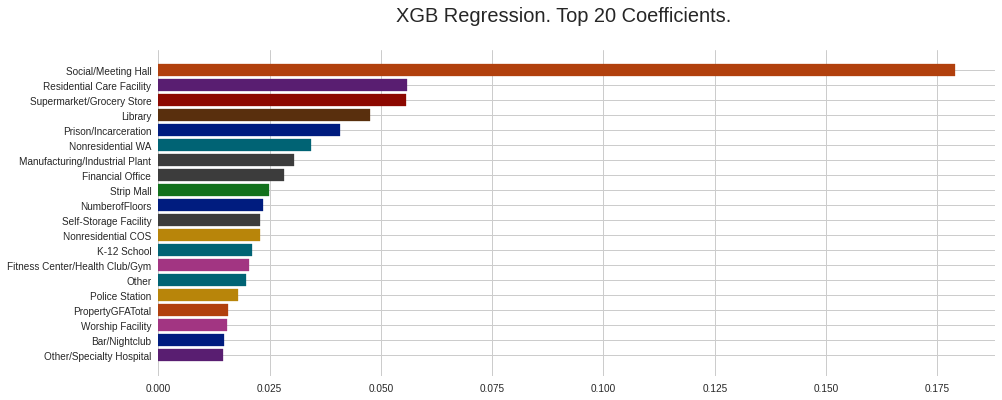

In [34]:
plt.figure(figsize=(15,6))
color_list =  sns.color_palette("dark", len(attributes)) 
top_x = 20
#logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_[0]
idx = np.argsort(np.abs(feature_importance))[::-1] 
lreg_ax = plt.barh(liste_coefs_rer["Features"][idx[:top_x]][::-1], liste_coefs_rer["Coefficient"][idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("XGB Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")


In [23]:
!pip install shap
import shap
shap.initjs()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


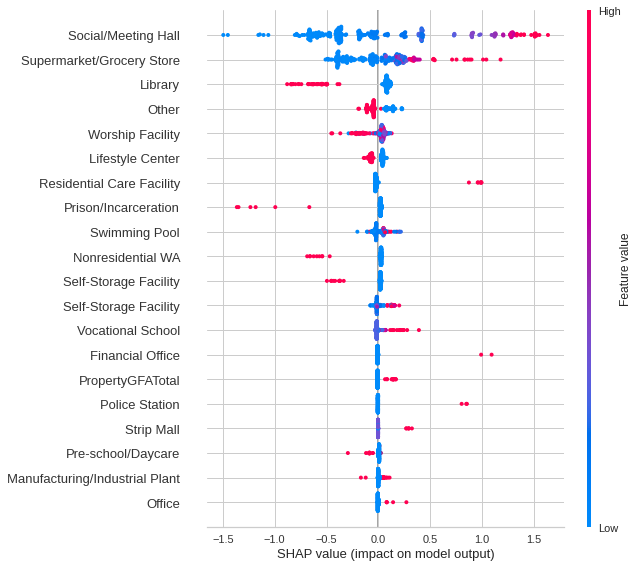

In [49]:

# explain all the predictions in the test set
explainer = shap.Explainer(final_model_energy)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test,feature_names=attributes)

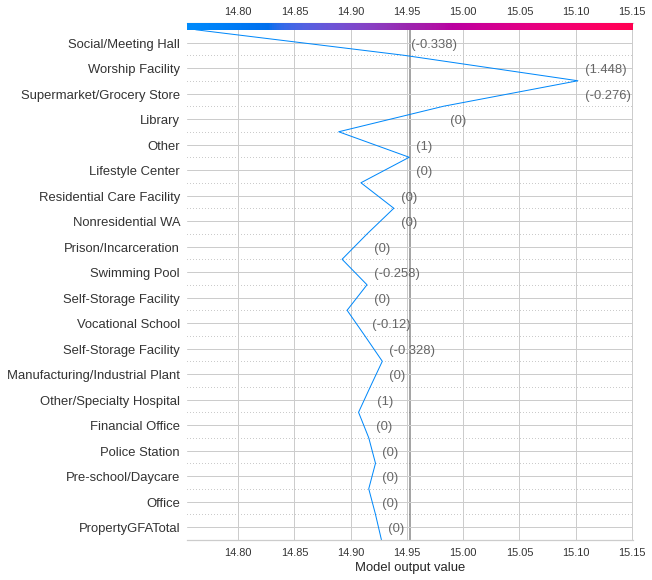

In [46]:
explainer = shap.Explainer(final_model_energy)
expected_value = explainer.expected_value
#print("The expected value is ", expected_value)
#print("The final prediction is ", xgb_model.predict(X_test)[0])
shap_values = explainer.shap_values(X_test)[0]
shap.decision_plot(expected_value, shap_values, X_test, feature_names=attributes)

In [ ]:
importances.sort_values("Features Importances", ascending=False).head(10)

,Features,Features Importances
141,Social/Meeting Hall,0.179
143,Supermarket/Grocery Store,0.056
54,Residential Care Facility,0.056
25,Library,0.047
50,Prison/Incarceration,0.041
9,Nonresidential WA,0.034
27,Manufacturing/Industrial Plant,0.031
17,Financial Office,0.028
142,Strip Mall,0.025
57,Self-Storage Facility,0.023


L'analyse de l'importance des features montre que le type d'usage va être un des points importants de notre modèle. Il va s'agir des types d'usage secondaire ou tertiaire essentiellement. La présence d'un Social/Meeting Hall,Residential Care Facility et Supermarket/Grocery Store vont avoir un rôle à jouer même si cela sera moins important. 

### **5- Pipeline du modèle pour l'estimation de la consommation d'énergie**

In [ ]:
# création de pipeline contenant la transformation des variables et le modèle entraîné
# elle peut être utilisée pour faire des prédictions sur de nouvelles variables

full_pipeline_energy = Pipeline([
    ("preprocessing", preprocessor),
    ("model", final_model_energy)
])

Le modèle choisi est prêt à être déployé pour pouvoir prédire la consommation d'énergie. Il pourra être intéressant de le réentraîner en ne faisant aucune modification logarithmique de notre cible. 

## **II- Prédiction de la consomation d'énergie  avec EnergyStar score**

Cette fois-ci, on va regarder si l'ajout du score ENERGY STAR va permettre d'améliorer notre modèle.


In [ ]:
#data=data.sample(frac=0.5,random_state=60)

In [ ]:
# Création d'un jeu d'entrainement (train set) et d'un jeu de test (test set)
# Stratification sur la variable "type de propriété"
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)


In [ ]:
y_train_s = train_set[["SiteEnergyUseWN(kBtu)_log"]]
y_test_s = test_set[["SiteEnergyUseWN(kBtu)_log"]]
X_train_s = train_set.drop([ "SiteEnergyUseWN(kBtu)_log",'SiteEnergyUseWN(kBtu)', "TotalGHGEmissions",'YearBuilt','DataYear','Latitude','Longitude'], axis=1)
X_test_s = test_set.drop([ "SiteEnergyUseWN(kBtu)_log", 'SiteEnergyUseWN(kBtu)',"TotalGHGEmissions",'YearBuilt','DataYear','Latitude','Longitude'], axis=1)


In [ ]:
# Séparation des variables catégorielles et numériques
cat_var = X_train_s.select_dtypes('object').columns.tolist()
num_var = X_train_s.select_dtypes('int64').columns.tolist()+X_train_s.select_dtypes('float').columns.tolist()


In [ ]:
# Création d'un pipeline de transformation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [ ]:
# transformation des variables
X_train_s = preprocessor.fit_transform(X_train_s)
X_test_s= preprocessor.transform(X_test_s)

In [ ]:
results = pd.DataFrame({})

**1-Modèle base line**

In [ ]:
from numpy.core.function_base import linspace
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor()
parameters={'strategy':['mean', 'median', 'quantile','constant'],
            'quantile': linspace(0.01, 1.0,5),
            'constant' : ['float','int']}
dummy_grid=GridSearchCV(dummy_reg,parameters,cv=5)  
training_start = time.perf_counter()
dummy_reg.fit(X_train_s, y_train_s)
training_end = time.perf_counter() 

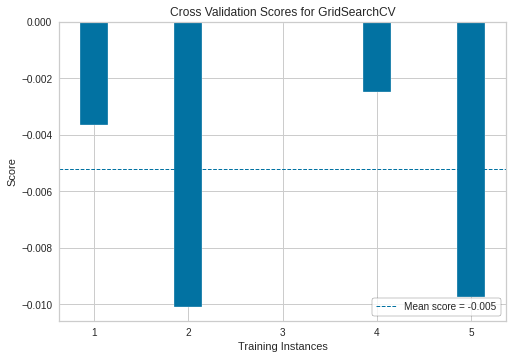

In [ ]:
from yellowbrick.model_selection import cv_scores
# Instantiate the regression model and visualizer
#cv = KFold(n_splits=12, shuffle=True, random_state=42)

model = dummy_grid
visualizer1 = cv_scores(model, X_train_s, y_train_s, scoring='r2')

In [ ]:
visualizer1.cv_scores_mean_

-0.005197958114022017

In [ ]:
dummy_reg_train_time=training_end-training_start

In [ ]:
dummy_reg.score(X_train_s,y_train_s)

0.0

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Dummyregressor'],
    'Train_Score' : [dummy_reg.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer1.cv_scores_mean_],'Time_train':[dummy_reg_train_time]}),ignore_index=True)

**2- ElasticNet**

In [ ]:
from sklearn.linear_model import ElasticNet
#rappel de la fonction de coût du elasticnet
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

parameters = {'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)}#L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge

elastic_grid = GridSearchCV(estimator = ElasticNet(), 
                      param_grid = parameters,cv=5)
                      
training_start_elast = time.perf_counter()
elastic_grid.fit(X_train_s, y_train_s)
training_end_elast = time.perf_counter()  

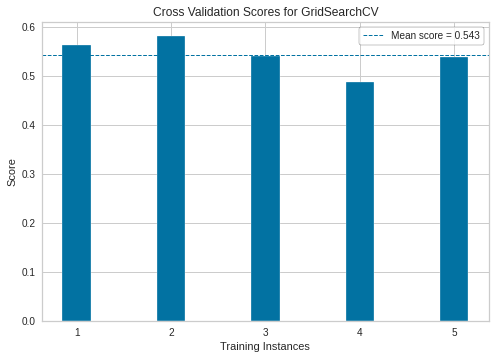

In [ ]:
visualizer2 = cv_scores(elastic_grid, X_train_s, y_train_s, scoring='r2')

In [ ]:
elastic_grid_train_time=training_end_elast-training_start_elast

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['ElasticNet'],
    'Train_Score' : [elastic_grid.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer2.cv_scores_mean_],'Time_train':[elastic_grid_train_time]}),ignore_index=True)

**3- SVR**

In [ ]:
from sklearn.svm import SVR

parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation

svm = GridSearchCV(estimator = SVR(), 
                      param_grid = parameters,cv=5)
training_start_svm = time.perf_counter()
svm.fit(X_train_s, y_train_s)
training_end_svm = time.perf_counter()   
               



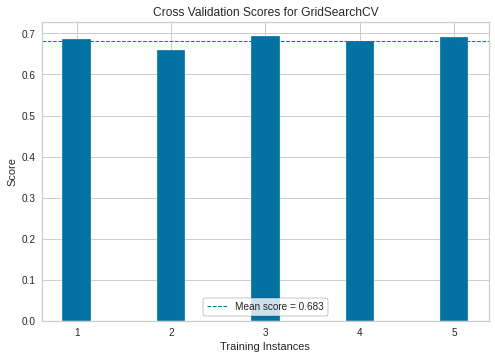

In [ ]:
visualizer3= cv_scores(svm, X_train_s, y_train_s, scoring='r2')

In [ ]:
svm_train_time=training_end_svm-training_start_svm

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['SVR'],
    'Train_Score' : [svm.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer3.cv_scores_mean_],'Time_train':[svm_train_time]}),ignore_index=True)

* **RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators' : [50,100,300,500], #nombre d'arbres de décision
    'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
}    
        
rfr_search = GridSearchCV(RandomForestRegressor(),parameters, cv=5)
training_start_rfr = time.perf_counter()
rfr_search.fit(X_train_s, y_train_s)
training_end_rfr = time.perf_counter()   
               

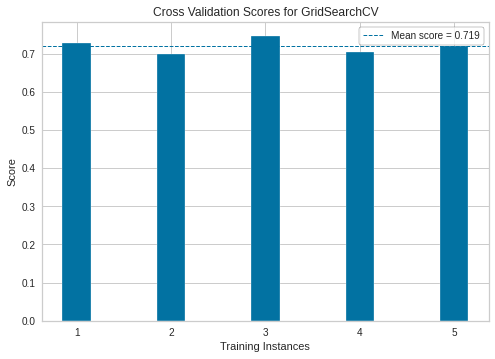

In [ ]:
visualizer4= cv_scores(rfr_search, X_train_s, y_train_s, scoring='r2')

In [ ]:
rfr_search_train_time=training_end_rfr-training_start_rfr

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['Randomforest'],
    'Train_Score' : [rfr_search.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer4.cv_scores_mean_],'Time_train':[rfr_search_train_time]}),ignore_index=True)

* **XGBOOST**

In [ ]:
from scipy.stats import randint
import xgboost as xgb
xgboost = xgb.XGBRegressor(n_jobs=-1)
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              "n_estimators" :[200,500,800,1000]}
xgb_search = GridSearchCV(xgboost,parameters,cv=5)
training_start_xgb = time.perf_counter()
xgb_search.fit(X_train_s, y_train_s)
training_end_xgb = time.perf_counter()   
               

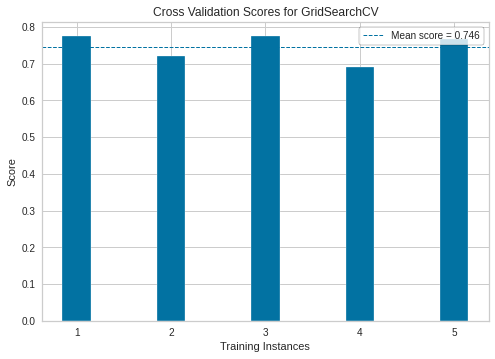

In [ ]:
visualizer5= cv_scores(xgb_search, X_train_s, y_train_s, scoring='r2')

In [ ]:
xgb_train_time=training_end_xgb-training_start_xgb

In [ ]:
results=results.append(pd.DataFrame({
    'Modèle' : ['XGBOOST'],
    'Train_Score' : [xgb_search.score(X_train_s,y_train_s)],'cv_scores_mean_':[visualizer5.cv_scores_mean_],'Time_train':[xgb_train_time]}),ignore_index=True)

* **Comparaison des modèles**

In [ ]:
results

,Modèle,Train_Score,cv_scores_mean_,Time_train
0,Dummyregressor,0.000000,-0.005198,0.009992
1,ElasticNet,0.626214,0.542642,59.386749
2,SVR,0.884327,0.682518,103.979261
3,Randomforest,0.963030,0.719354,163.822779
4,XGBOOST,0.857643,0.745753,53.352457


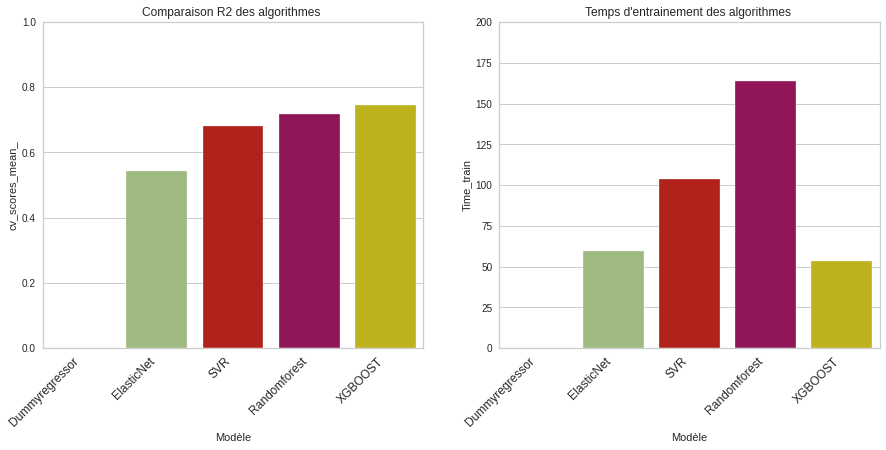

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Comparaison R2 des algorithmes ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,2])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 1])
plt.subplot(1,2,2)
plt.title('Temps d\'entrainement des algorithmes ')
chart = sns.barplot(x = results.iloc[:,0],
           y = results.iloc[:,3])
chart.set_xticklabels(labels = results.iloc[:,0], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 200])
plt.show()

* **XGBOOST** et **Randomforest** ont les meilleurs score de crosse avlidation par rapport aux autres modèles. De plus le temps d'exécution de XGBoost est plus faible que celui de random forest, ceci pourrait être un critère pour choisir toujours XGBoost plutôt que  Random Forest Regressor.

* **Analyse des erreurs du modèles**

In [ ]:
final_model_energy_s = xgb_search.best_estimator_
final_predictions_energy_s = final_model_energy_s.predict(X_test_s)
regression_metrics(np.array(y_test_s), final_predictions_energy_s)

MAE:  0.39676
MSE:  0.30218
RMSE:  0.5497060026921847
RMPSE:  0.118
MAPE:  0.02746
R²:  0.81696


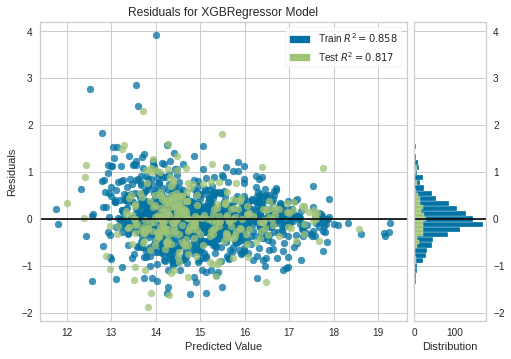

In [ ]:
visualizer_s = ResidualsPlot(final_model_energy_s)
visualizer_s.fit(np.array(X_train_s), np.array(y_train_s).reshape( 1226,))
visualizer_s.score(np.array(X_test_s), np.array(y_test_s).reshape(307 ,))
visualizer_s.show();

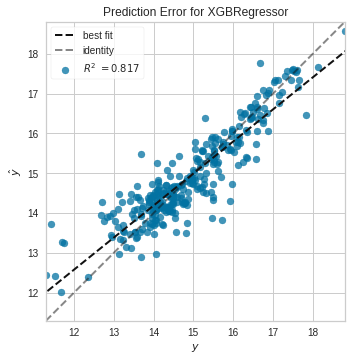

In [ ]:
visualizer_s= prediction_error(final_model_energy_s, np.array(X_train_s), np.array(y_train_s), np.array(X_test_s), np.array(y_test_s));

**Interet de l'energystar score**

In [ ]:
def met(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmpse_cal = rmpse(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    return[mae,mse,rmse,rmpse_cal,mape,r_score]

In [ ]:
metric=pd.DataFrame({'Metrics':['MAE','MSE','RMSE','RMPSE','MAPE','R2'],'Sans_Energystar_Score':met(np.array(y_test), final_predictions_energy),'Avec_EnergyStar_Score':met(np.array(y_test_s), final_predictions_energy_s)})
metric

,Metrics,Sans_Energystar_Score,Avec_EnergyStar_Score
0,MAE,0.457619,0.396760
1,MSE,0.377220,0.302177
2,RMSE,0.614183,0.549706
3,RMPSE,0.117217,0.117600
4,MAPE,0.031766,0.027462
5,R2,0.771503,0.816960


L'ajout de la variable energy star score améliore légermenent les performances du modèles.

## Conclusion

Les informations dont l'on dispose nous permette d'avoir une bonne prédiction de la consommation d'énergie. On dispose d'un modèle qui capture les 3/4 de la variance de notre phénomène. Les erreurs de prédictions sont plutôt faibles : une erreur de plus ou moins 0.1% est commise par notre modèle.